## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt



##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
from sklearn.utils import class_weight

import tensorflow as tf
from skimage import io
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Reshape
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
74112,00018224_014.png,Edema|Infiltration|Pneumonia|Pneumothorax,14,18224,59,M,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00018224_014.png
96373,00025368_017.png,Nodule,17,25368,42,M,PA,2858,2843,0.143,0.143,NaN,/data/images_011/images/00025368_017.png
51826,00013089_001.png,Atelectasis,1,13089,50,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00013089_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_df = all_xray_df[['Image Index','Finding Labels']]
all_xray_df.sample(3)

,Image Index,Finding Labels
91212,00022740_003.png,Nodule
45213,00011598_009.png,No Finding
32262,00008451_004.png,Mass


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda label: "with_Pneumonia" if label else "without_Pneumonia")
all_xray_df['img_path'] = all_xray_df['Image Index'].map(lambda idx: all_image_paths[idx])
all_xray_df.sample(3)

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,img_path
30214,00007879_002.png,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,without_Pneumonia,/data/images_004/images/00007879_002.png
8897,00002345_009.png,Infiltration,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,without_Pneumonia,/data/images_002/images/00002345_009.png
84137,00020675_002.png,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,without_Pneumonia,/data/images_009/images/00020675_002.png


In [5]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']
all_xray_df.sample(3)

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,img_path
21261,00005681_015.png,Emphysema,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_003/images/00005681_015.png
103159,00027492_001.png,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/data/images_011/images/00027492_001.png
74843,00018366_003.png,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/data/images_008/images/00018366_003.png


## Create your training and testing data:

In [7]:


def create_splits(df, test_size, column_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_df, valid_df = skl.train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[column_name])
    ## making equal proportions of Pneumonia in both sets!
    # traing data
    p_inds = train_df[train_df[column_name] == 1].index.tolist()
    np_inds = train_df[train_df[column_name] ==0].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    # validation data
    p_inds = valid_df[valid_df[column_name]==1].index.tolist()
    np_inds = valid_df[valid_df[column_name]==0].index.tolist()

    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    return train_df, valid_df




In [8]:
train_df, valid_df = create_splits(all_xray_df, 0.2, 'pneumonia_class')

In [9]:
len(train_df)

2290

In [10]:
#REVIEW 1: Checking the size of train data
train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [11]:
#REVIEW 1: Checking the size of validation data
valid_df['pneumonia_class'].sum()/len(valid_df)

0.2

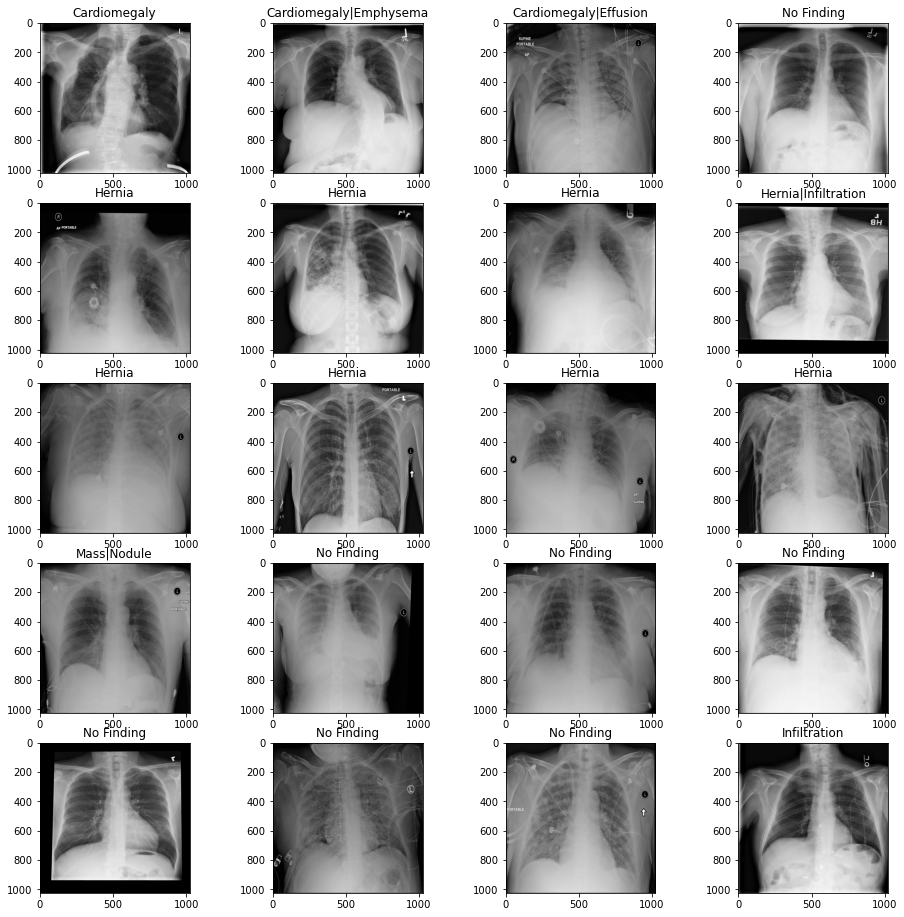

In [12]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_df['Image Index']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(all_image_paths[img])
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[ind]['Finding Labels'])
    ind=ind+1

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
img_size = (224, 224)

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo

# REVIEW 1: Changed the image augmentation analysis
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=25, 
                              shear_range = 0.1,
                              zoom_range=0.05)
    return my_idg



def make_train_gen(train_data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    #     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
    #                                          directory=None, 
    #                                          x_col = ,
    #                                          y_col = ,
    #                                          class_mode = 'binary',
    #                                          target_size = , 
    #                                          batch_size = 
    #                                          )
    # Todo
    IMG_SIZE = (224, 224)
    train_idg = my_image_augmentation()
    train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = 32
                                         )
    return train_gen


def make_val_gen(valid_data):
    
    #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
    #                                              directory=None, 
    #                                              x_col = ,
    #                                              y_col = ',
    #                                              class_mode = 'binary',
    #                                              target_size = , 
    #                                              batch_size = ) 

    # Todo

# REVIEW 1: Changed the image augmentation analysis here to so it becomes different. 
    val_idg = ImageDataGenerator(rescale=1./255.)
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_data, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = 64)
    return val_gen

In [14]:
train_df['pneumonia_class'] = train_df['pneumonia_class'].astype(str)
valid_df['pneumonia_class'] = valid_df['pneumonia_class'].astype(str)

In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(valid_df)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen(train_df)

Found 2290 validated image filenames belonging to 2 classes.


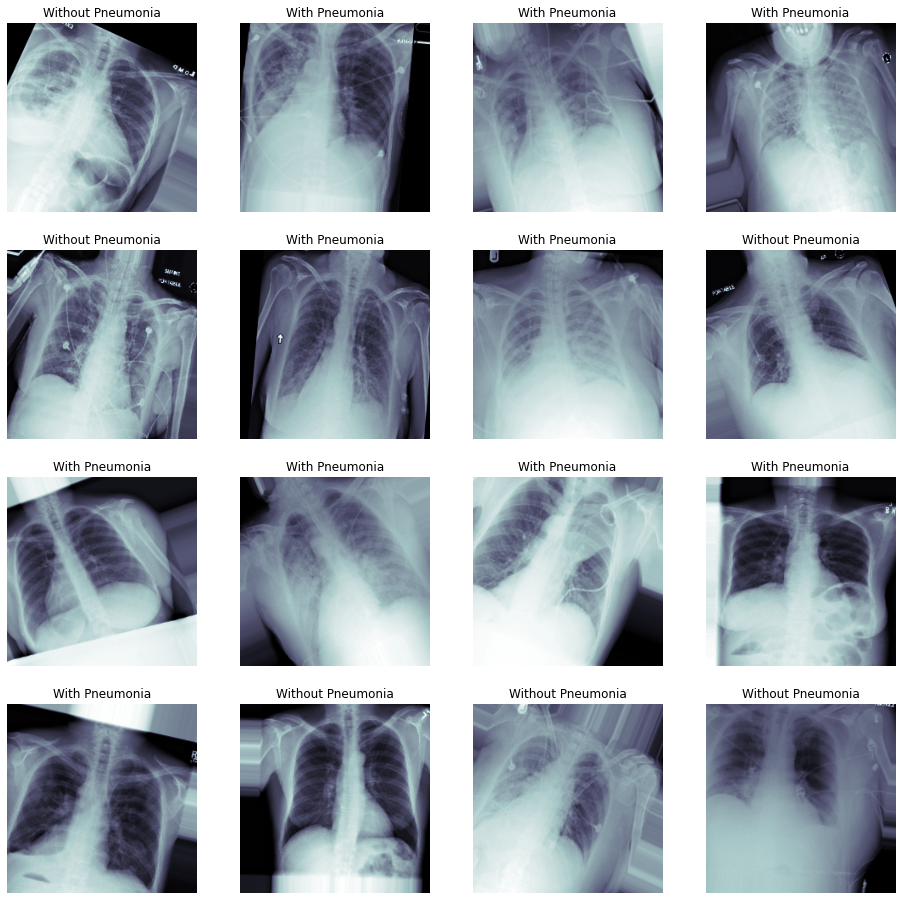

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('With Pneumonia')
    else:
        c_ax.set_title('Without Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    '''
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    '''
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    VGG_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return VGG_model


In [19]:
def build_my_model():
    
    '''
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # 
    '''
    
    vgg_model = load_pretrained_model()
    
    # REVIEW 1: I'm freezing the layers of VGG as requested (leaving only the last as you suggested)
    
    for layer in vgg_model.layers[:]:
        layer.trainable = False

    
    for layer in vgg_model.layers:
        print(layer, layer.trainable)
    
    # REVIEW 1: Remove the conv and add the dense layers, as suggested
    
    my_model = Sequential([vgg_model,
                           Flatten(),
                        BatchNormalization(),
                        Dense(1024, activation='relu'),
                        #Conv2D(1024, 1, activation='relu'),
                        Dropout(0.5),
                        #BatchNormalization(),
                        Dense(512, activation='relu'),
                        #Conv2D(256, 1, activation='relu'),
                        Dropout(0.5),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(1, activation='sigmoid'),
                        #AveragePooling2D((7,7)),
                        #BatchNormalization(),
                        #Conv2D(1, 1, activation='sigmoid'),
                        Reshape((-1,))
                       ])
    return my_model





In [20]:
my_model = build_my_model()
my_model.summary()
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

553467904/553467096 [==============================] - 7s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7ff2b2c03e50> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b2c031d0> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b48c1950> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff2b2c3dc10> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b43ef3d0> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b2c0ee90> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff2b25a5750> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b25a5110> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b25b0e10> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b25b0e50> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff2b25b5a10> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b25b9410> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b25bf810> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b25c5b50>

In [21]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

#weight_path="{}_my_model.best.hdf5".format('xray_class')

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

weight_path="my_model.hdf5"

'''
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'max', 
                      patience=5)

callbacks_list = [checkpoint, early]
'''

my_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath=weight_path, save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [22]:
import multiprocessing as mp
cpu_count = mp.cpu_count()
cpu_count

4

### Start training! 

In [23]:
## train your model

#optimizer = Adam(
#    learning_rate=0.001,
#    beta_1=0.9,
#    beta_2=0.999,
#    epsilon=1e-07,
#    amsgrad=False)
#optimizer = RMSprop(learning_rate=1e-4)
#loss = tf.keras.losses.BinaryCrossentropy()
#metrics = [tf.keras.metrics.BinaryAccuracy()]

batch_size = 32
epochs = 10
'''
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10,
                          callbacks = callbacks_list)
'''
history = my_model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=(valX, valY), 
           validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


Epoch 1/10
71/71 [==============================] - 71s 1s/step - loss: 2.4199 - accuracy: 0.5381 - val_loss: 0.7038 - val_accuracy: 0.4531
Epoch 2/10
71/71 [==============================] - 65s 915ms/step - loss: 1.5206 - accuracy: 0.5394 - val_loss: 0.6830 - val_accuracy: 0.5312
Epoch 3/10
71/71 [==============================] - 83s 1s/step - loss: 0.9068 - accuracy: 0.5266 - val_loss: 0.6933 - val_accuracy: 0.4688

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
71/71 [==============================] - 61s 853ms/step - loss: 0.7863 - accuracy: 0.5292 - val_loss: 0.6810 - val_accuracy: 0.6562
Epoch 5/10
71/71 [==============================] - 58s 821ms/step - loss: 0.7362 - accuracy: 0.5571 - val_loss: 0.6837 - val_accuracy: 0.6406

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
71/71 [==============================] - 59s 836ms/step - loss: 0.7300 - accuracy: 0.5546 - val_loss: 0.6802 - val_acc

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 200, verbose = True)
# mapping in range of [0,1]
max(pred_Y), min(pred_Y)

64/64 [==============================] - 6s 86ms/step


(array([0.5657853], dtype=float32), array([0.4503492], dtype=float32))

In [25]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate',fontsize=12)
    c_ax.set_ylabel('True Positive Rate',fontsize=12)
    return

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall',fontsize=12)
    c_ax.set_ylabel('Precision',fontsize=12)

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)

#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset",fontsize=12)
    plt.xlabel("Epoch #",fontsize=12)
    plt.ylabel("Loss/Accuracy",fontsize=12)
    plt.legend(loc="upper left",fontsize=12)

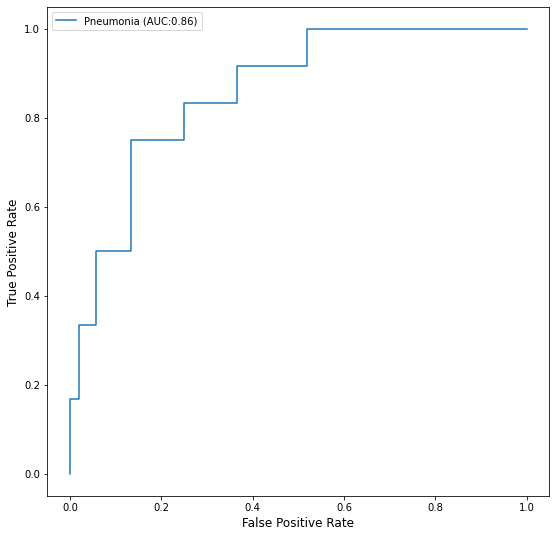

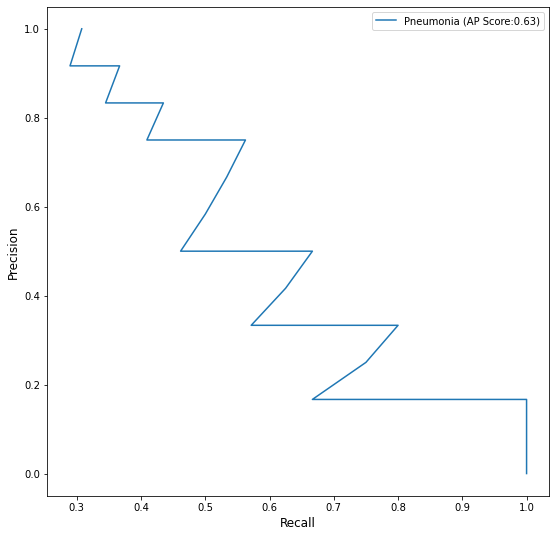

In [26]:
## plot figures


auc = plot_auc(valY, pred_Y)
plt.savefig('AUC.png')
plot_pr(valY, pred_Y)
pr = plt.savefig('PR.png')

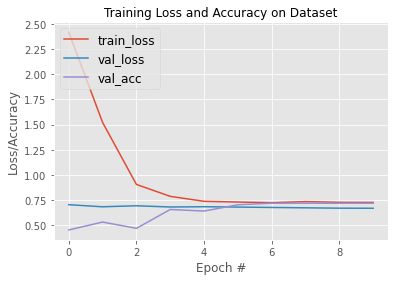

In [27]:
plot_history(history)
plt.savefig('history.png')

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [28]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [29]:
# Look at the threshold where precision is 0.8
precision_value = 0.8
idx1 = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx1]))
print('Recall is: '+ str(recall[idx1]))
print('Threshold is: '+ str(thresholds[idx1]))
print('F1 Score is: ' + str(calc_f1(precision[idx1],recall[idx1])))
thresh1 = thresholds[idx1]
print('---------------------------------')

Precision is: 0.8
Recall is: 0.3333333333333333
Threshold is: 0.5445839
F1 Score is: 0.47058823529411764
---------------------------------


In [30]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx2 = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx2]))
print('Recall is: '+ str(recall[idx2]))
print('Threshold is: '+ str(thresholds[idx2]))
print('F1 Score is: ' + str(calc_f1(precision[idx2],recall[idx2])))
thresh2 = thresholds[idx2]
print('---------------------------------')

Precision is: 0.3448275862068966
Recall is: 0.8333333333333334
Threshold is: 0.49264127
F1 Score is: 0.4878048780487806
---------------------------------


In [31]:
acc = accuracy_score(valY, np.round(pred_Y))*100
cm = confusion_matrix(valY, np.round(pred_Y), labels=[1,0])
tn, fp, fn, tp = cm.ravel()
print('**** TEST METRICS ****')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print('---------------------------------')

**** TEST METRICS ****
Accuracy: 71.875%
Precision: 94.73684210526315%
Recall: 69.23076923076923%
F1-score: 79.99999999999999
---------------------------------


In [32]:
print('**** CONFUSION MATRIX ****')
print(cm)

**** CONFUSION MATRIX ****
[[10  2]
 [16 36]]


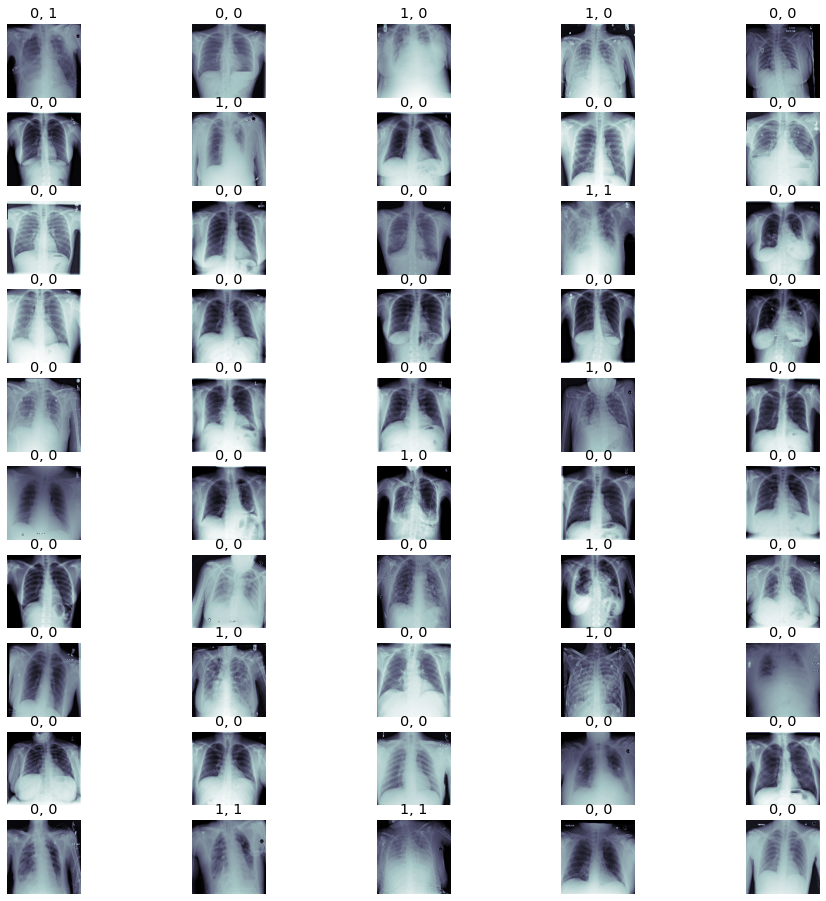

In [33]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:50], valY[0:50], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresholds[idx1]:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresholds[idx1]: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [35]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)